In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


In [2]:
df = pd.read_csv("patterns.csv")

# Ensure date is a datetime 
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")  

# Clean up the pattern column (replace missing with 'no-pattern', ensure string type)
df["pattern"] = df["pattern"].fillna("no-pattern").astype(str)

# The distribution of labels (not used for grouping)
pattern_counts = df["pattern"].value_counts()
print(pattern_counts)


pattern
no-pattern       11909
BearButterfly      910
BearShark          782
BullBat            734
BullButterfly      703
BearCrab           569
BullShark          544
BullGartley        430
BullCrab           310
BullCypher         254
BearGartley        197
BearCypher         131
BearBat             23
Name: count, dtype: int64


In [3]:
# Create a shifted version of pattern to compare with previous row
df["pattern_shift"] = df["pattern"].shift(1)

# Whenever pattern changes from previous row, we start a new group
df["new_group"] = (df["pattern"] != df["pattern_shift"]).astype(int)

# Cumulative sum of new_group gives us a unique group id
df["group_id"] = df["new_group"].cumsum()

# See how many groups there are
num_groups = df["group_id"].nunique()
print("Number of groups (pattern segments):", num_groups)


Number of groups (pattern segments): 201


In [4]:
FEATURE_COLS = ["price", "close", "high", "low", "open", "r"]
SEQ_LEN = 64

X_sequences = []
y_labels = []

for gid, group in df.groupby("group_id"):
    label = group["pattern"].iloc[0]
    
    # Extract selected features
    feat = group[FEATURE_COLS].values  # shape: (group_len, num_features)

    # Handle missing r if there are any:
    # Fill NaN in r with 0 before this loop:
    # df["r"] = df["r"].fillna(0)

    # Make fixed-length sequence
    if len(feat) >= SEQ_LEN:
        # take last 64 rows of this group
        seq = feat[-SEQ_LEN:]
    else:
        # pad at the beginning by repeating the first row
        pad_len = SEQ_LEN - len(feat)
        pad = np.repeat(feat[0:1, :], pad_len, axis=0)
        seq = np.concatenate([pad, feat], axis=0)

    X_sequences.append(seq)
    y_labels.append(label)

X = np.stack(X_sequences)  # shape: (num_groups, SEQ_LEN, num_features)
y = np.array(y_labels)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (201, 64, 6)
y shape: (201,)


In [5]:
# 1. Drop "no-pattern" sequences
mask = y != "no-pattern"
X_hp = X[mask]      # harmonic pattern sequences only
y_hp = y[mask]      # corresponding labels

print("X_hp shape:", X_hp.shape)
print("y_hp shape:", y_hp.shape)

# 2. Label encode the harmonic pattern names
le = LabelEncoder()
y_encoded = le.fit_transform(y_hp)

print("Classes:", le.classes_)
print("Encoded labels example:", y_encoded[:10])
num_classes = len(le.classes_)


X_hp shape: (116, 64, 6)
y_hp shape: (116,)
Classes: ['BearBat' 'BearButterfly' 'BearCrab' 'BearCypher' 'BearGartley'
 'BearShark' 'BullBat' 'BullButterfly' 'BullCrab' 'BullCypher'
 'BullGartley' 'BullShark']
Encoded labels example: [ 7  2  2  2  7 10  3  8  7  4]


In [6]:
print("Label counts at SEQUENCE level:")
print(Counter(y_hp))

print("\nEncoded label counts at SEQUENCE level:")
print(Counter(y_encoded))


Label counts at SEQUENCE level:
Counter({'BullButterfly': 18, 'BearShark': 17, 'BullBat': 16, 'BearButterfly': 15, 'BullGartley': 10, 'BearCrab': 9, 'BullShark': 9, 'BullCrab': 8, 'BearGartley': 6, 'BearCypher': 4, 'BullCypher': 3, 'BearBat': 1})

Encoded label counts at SEQUENCE level:
Counter({7: 18, 5: 17, 6: 16, 1: 15, 10: 10, 2: 9, 11: 9, 8: 8, 4: 6, 3: 4, 9: 3, 0: 1})


In [7]:
# Since there is only 1 sequence of BearBat, we cannot use stratify this time. So we will skip it for now and use it when we try Oversampling
X_train, X_temp, y_train, y_temp = train_test_split(
    X_hp, y_encoded,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    shuffle=True
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (81, 64, 6) (81,)
Val:   (17, 64, 6) (17,)
Test:  (18, 64, 6) (18,)


In [8]:
#standartization step

# X_train, X_val, X_test currently have shape: (samples, 64, 6)
num_features = X_train.shape[2]
SEQ_LEN = X_train.shape[1]

scaler = StandardScaler()


X_train_2d = X_train.reshape(-1, num_features)  # (81*64, 6)
scaler.fit(X_train_2d)

# Transform train/val/test
def transform_with_scaler(X, scaler):
    s, t, f = X.shape  # samples, timesteps, features
    X_2d = X.reshape(-1, f)
    X_scaled_2d = scaler.transform(X_2d)
    return X_scaled_2d.reshape(s, t, f)

X_train_scaled = transform_with_scaler(X_train, scaler)
X_val_scaled   = transform_with_scaler(X_val, scaler)
X_test_scaled  = transform_with_scaler(X_test, scaler)


In [9]:
#Keeping the LSTM simple because our dataset is small

num_classes = len(le.classes_)   # should be 12

model = Sequential([
    Input(shape=(SEQ_LEN, num_features)),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             780 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,116 (90.30 KB)

 Trainable params: 23,116 (90.30 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.0988 - loss: 2.4874 - val_accuracy: 0.0588 - val_loss: 2.4661
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1605 - loss: 2.4400 - val_accuracy: 0.0588 - val_loss: 2.4860
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1481 - loss: 2.4111 - val_accuracy: 0.0588 - val_loss: 2.5059
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1358 - loss: 2.3533 - val_accuracy: 0.0588 - val_loss: 2.5294
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1481 - loss: 2.3597 - val_accuracy: 0.0588 - val_loss: 2.5408
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1358 - loss: 2.3131 - val_accuracy: 0.0588 - val_loss: 2.5455


In [11]:
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

labels = np.arange(num_classes)  # [0, 1, ..., 11]

print("Classification report:")
print(classification_report(
    y_test,
    y_pred,
    labels=labels,
    target_names=le.classes_,
    zero_division=0   # avoid warnings for classes with no samples
))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred, labels=labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Classification report:
               precision    recall  f1-score   support

      BearBat       0.00      0.00      0.00         1
BearButterfly       0.00      0.00      0.00         5
     BearCrab       0.00      0.00      0.00         2
   BearCypher       0.00      0.00      0.00         0
  BearGartley       0.00      0.00      0.00         0
    BearShark       0.00      0.00      0.00         2
      BullBat       0.00      0.00      0.00         0
BullButterfly       0.40      1.00      0.57         4
     BullCrab       0.00      0.00      0.00         2
   BullCypher       0.00      0.00      0.00         0
  BullGartley       0.00      0.00      0.00         2
    BullShark       0.00      0.00      0.00         0

     accuracy                           0.22        18
    macro avg       0.03      0.08      0.05        18
 weighted avg       0.09      0.22      0.13        18

Confusion matrix:
[[0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 

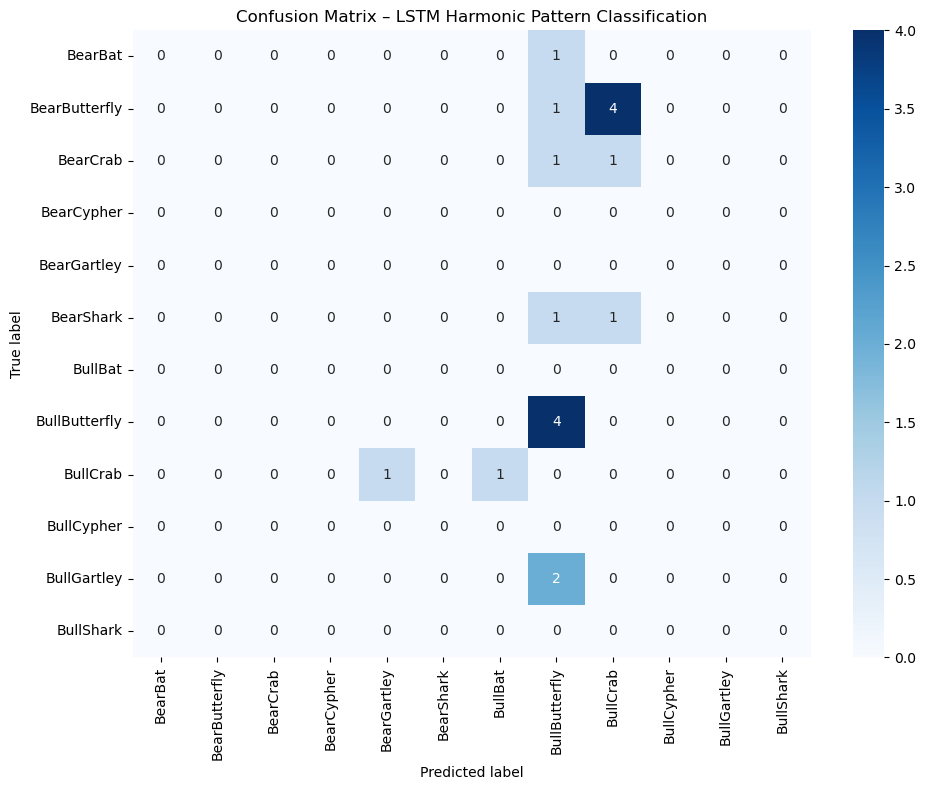

In [12]:
cm = confusion_matrix(
    y_test,
    y_pred,
    labels=labels
)

plt.figure(figsize=(10, 8))

sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – LSTM Harmonic Pattern Classification")
plt.tight_layout()
plt.show()